# Dekompozycja sezonowa

Dekompozycja sezonowa zakłada, że szereg czasowy składa się z 4 składników:
 - składnika sezonowego (S)
 - składnika trendu (T)
 - składnika cyklicznego (C)
 - składnika losowego błędu (I)

Róznica między składnikiem cyklicznym i sezonowym polega na tym,że składnik sezonowy pojawia się w regularnych odstępach, z kolei cykle charakteryzują się dłuższym czasem trwania oraz zmiennością czasu trwania cyklu. Zależność funkcyjna między trendem a cyklicznością mogą zostać przedstawione za pomocą dwóch modeli.


Import potrzebnych bibliotek:
- numpy - operacje numeryczne
- pandas - obsługa danych
- matplotlib - wykresy
- statsmodels - dostarcza metdoy seasonal_decompose() - do dekompozycji sezonowej

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = [15, 10]

Import danych:

Dane przedstawiają ilość pasażerów lini lotniczych na przestrzeni miesięcy lat 1949-1960

         #Passengers
Month               
1949-01          112
1949-02          118
1949-03          132
1949-04          129
1949-05          121
...              ...
1960-08          606
1960-09          508
1960-10          461
1960-11          390
1960-12          432

[144 rows x 1 columns]


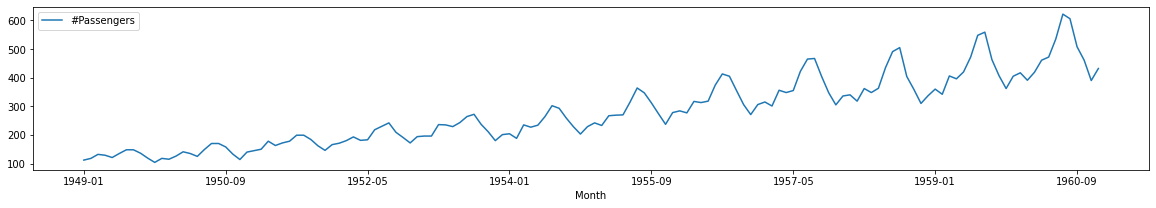

In [103]:
data = pd.read_csv("data/AirPassengers.csv", header=0, index_col=0)
print(data)
data.plot(figsize=(20,3))


Jeszcze przed dekompozycją można zauważyć, że liczba pasażerów wykazuje pewien trend (wzrostowy) oraz sezonowość.

In [105]:
def showData(data, model):
    dataCopy = pd.read_csv("data/AirPassengers.csv", header=0, index_col=0)
    dataCopy['observed'] = model.observed
    dataCopy['residual'] = model.resid
    dataCopy['seasonal'] = model.seasonal
    dataCopy['trend'] = model.trend
    dataCopy.plot(figsize=(20,3))

# Model addytywny

$Y = S + T + C + I$

gdzie:
 - składnika sezonowego (S)
 - składnika trendu (T)
 - składnika cyklicznego (C)
 - składnika losowego błędu (I)

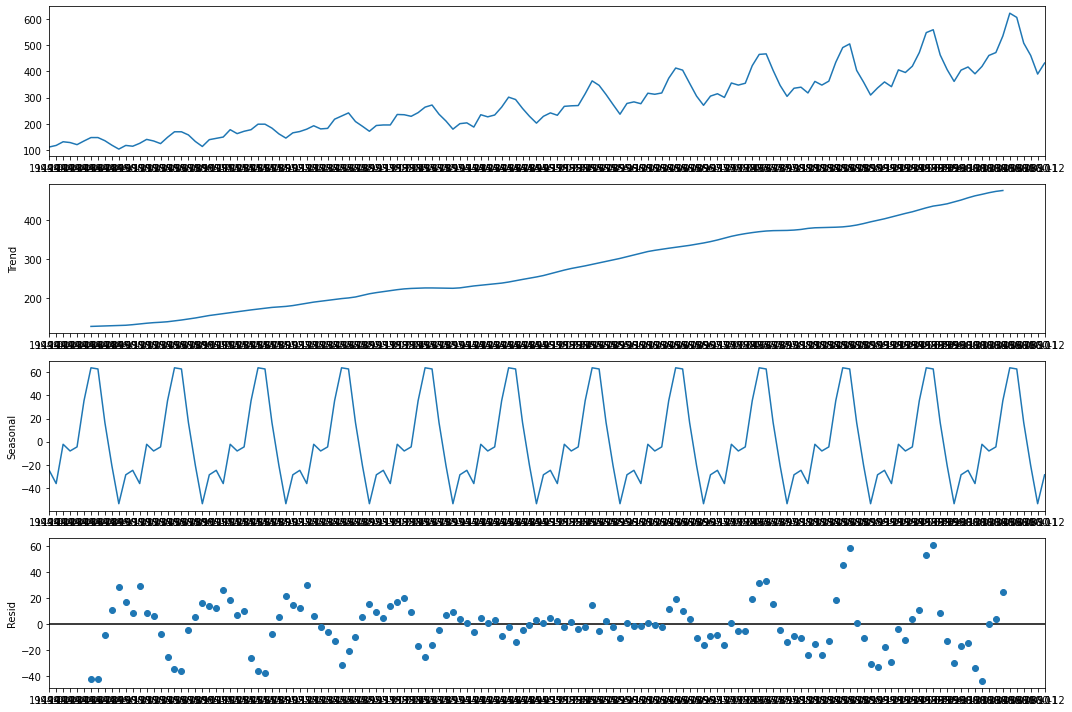

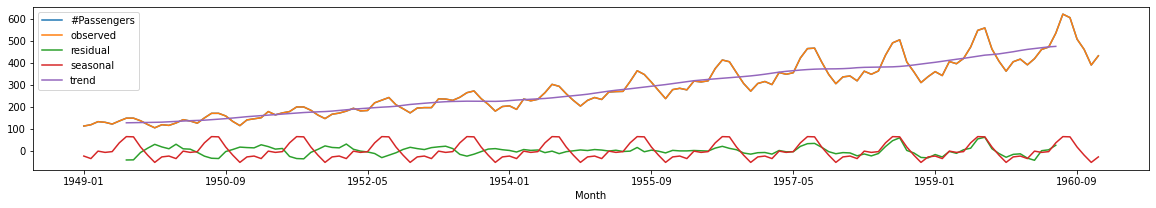

In [110]:
additiveModel = seasonal_decompose(data, model='additive', period=12)
additiveModel.plot()
plt.show()
showData(data, additiveModel)

# Model multiplikatywny

$Y = S * T * C * I$

gdzie:
 - składnika sezonowego (S)
 - składnika trendu (T)
 - składnika cyklicznego (C)
 - składnika losowego błędu (I)

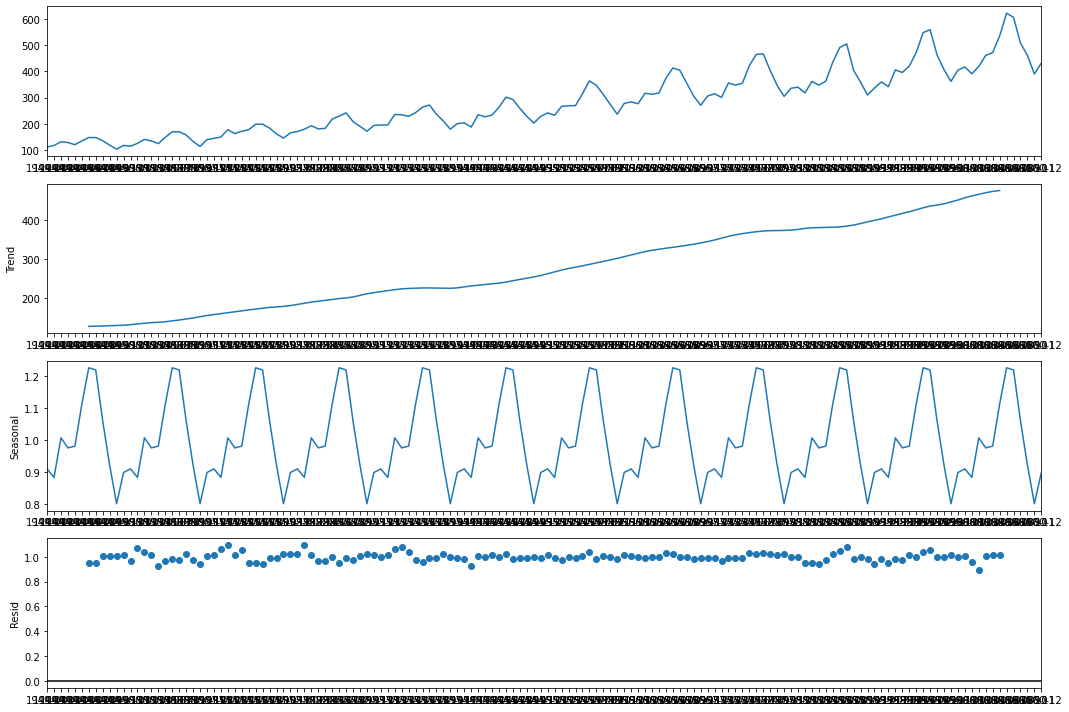

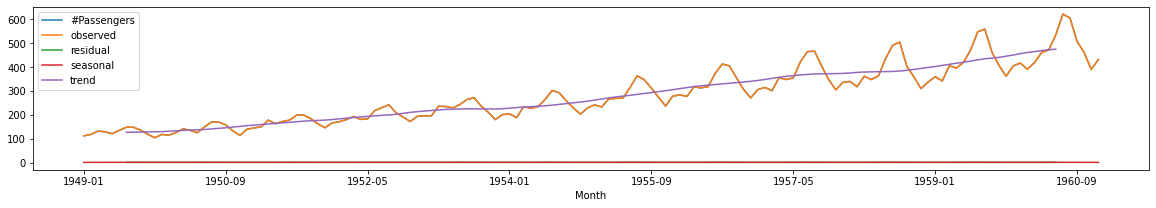

In [107]:
multiplicativeModel = seasonal_decompose(data, model='multiplicative', period=12)
multiplicativeModel.plot()
plt.show()
showData(data, multiplicativeModel)

# Wnioski

- otrzymane wykresy z obu modeli potwierdzają początkowe obserwacje o istnieniu sezonowści oraz trendu w szeregu czasowym
- cykl sezonu trwa w przybliżeniu 12 miesięcy
- w pierwszej połowie sezonu następuje wzrost z dwiema wyrażnymi korektami, a w drugiej spadek już bez korekt
- dla obu metod wykres sezonowości oraz trendu są do siebie bardzo zbliżone
- można zauważyć, że wykresy dla błedu ("Resid") znacząco się róznią dla obu metod. Dla metody addytywnej oscyluje w granicach [-40, 60] natomiast dla metody multiplikatywnej w okolicach 1. Wynika to z tego, że w tej pierwszej metodzie błąd jest dodawany do wyniku, natomiast w drugiej jest mnożony przez wynik.


# Dekompozycja bez użycia biblioteki

## Krok 1: 
Próba odgadnięcia długości cyklu trendu - w naszym przypadku możemy założyć, że wynosi on 12 miesięcy

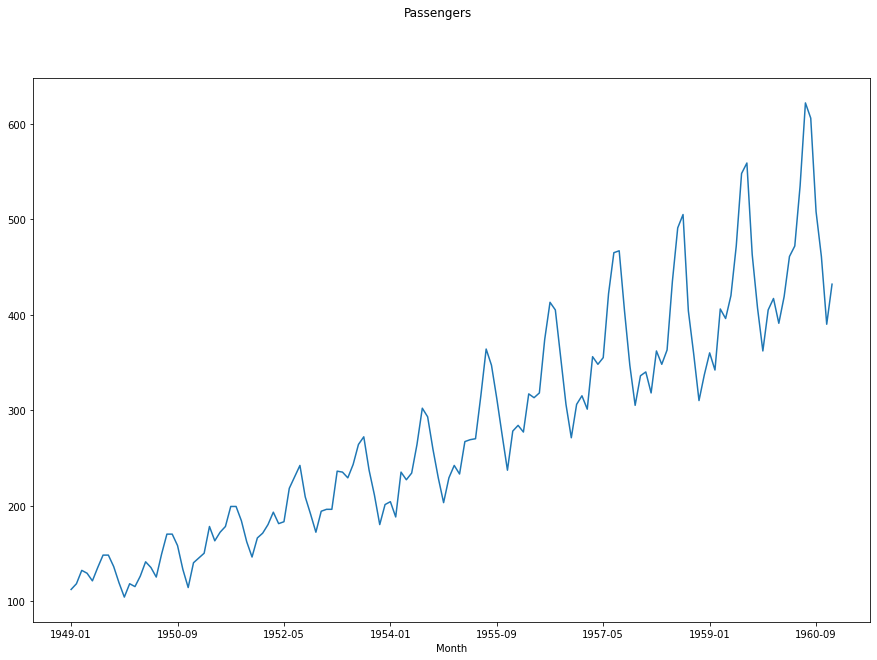

In [82]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt

df = pd.read_csv("data/AirPassengers.csv", header=0, index_col=0)
fig = plt.figure()
fig.suptitle('Passengers')
df['#Passengers'].plot()
plt.show()



## Krok 2: 
Obliczamy 13-miesięczną (6 miesięcy wsteczy, 6 miesięcy do przodu i 1 miesiący obecnie rozpatrywany) średnią ruchomą z wagą dla najdalszych 2 miesięcy (w cyklu rocznym) równą 1/24 i 1/12 dla pozostałych 11 miesięcy.



<ipython-input-83-da8b7772f273>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TREND'][i] = df['#Passengers'][i - 6] * 1.0 / 24 +(


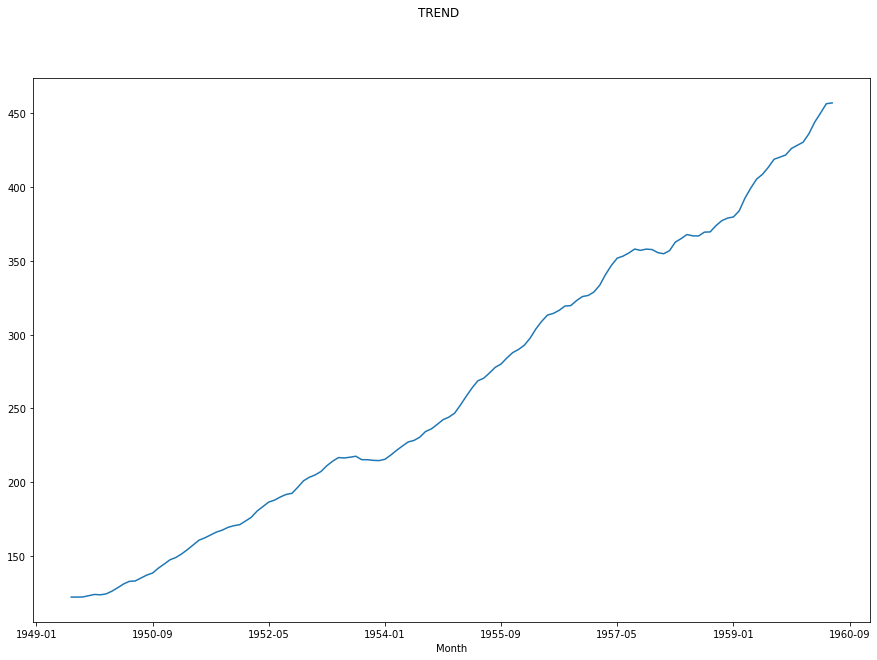

In [83]:
df['TREND'] = np.nan
for i in range(6, df['#Passengers'].size - 6):
    df['TREND'][i] = df['#Passengers'][i - 6] * 1.0 / 24 +(
        df['#Passengers'][i - 5] + 
        df['#Passengers'][i - 4] + 
        df['#Passengers'][i - 3] + 
        df['#Passengers'][i - 2] + 
        df['#Passengers'][i - 1] + 
        df['#Passengers'][i] + 
        df['#Passengers'][i + 1] + 
        df['#Passengers'][i + 2] + 
        df['#Passengers'][i + 3] + 
        df['#Passengers'][i + 4] + 
        df['#Passengers'][i + 5]
    ) * 1.0 / 12 
    + df['#Passengers'][i + 6] * 1.0 / 24
        
#plot the trend component
fig = plt.figure()
fig.suptitle('TREND')
df['TREND'].plot()
plt.show()

## Krok 3: 
Teraz należy podjąć decyzję o rodzaju modelu. W modelu addytywnym będziemy odejmować a w multiplikatywnym dzielić orginalny szereg z trendem. Po wykonaniu tej operacji otrzymamy wartości dla sezonowości wraz z błędem (szumem)



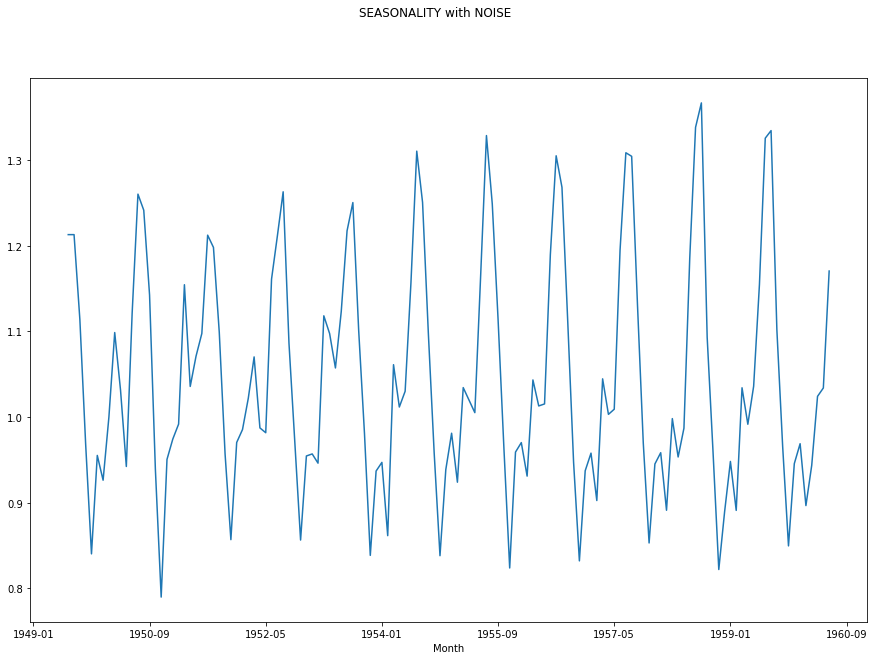

In [84]:
df['SEASONALITY_WITH_NOISE'] = df['#Passengers']/df['TREND']
fig = plt.figure()
fig.suptitle('SEASONALITY with NOISE')
df['SEASONALITY_WITH_NOISE'].plot()
 
plt.show()

## Krok 4:
Teraz oddzielimy 'czysty' składnik sezonowości od szumu poprzez policzenie średniego składnika sezonowego dla każdego z 12 miesięcy.

<ipython-input-94-501477c3a1e6>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SEASONALITY'][i] = average_seasonal_values[df['MONTH'][i]]


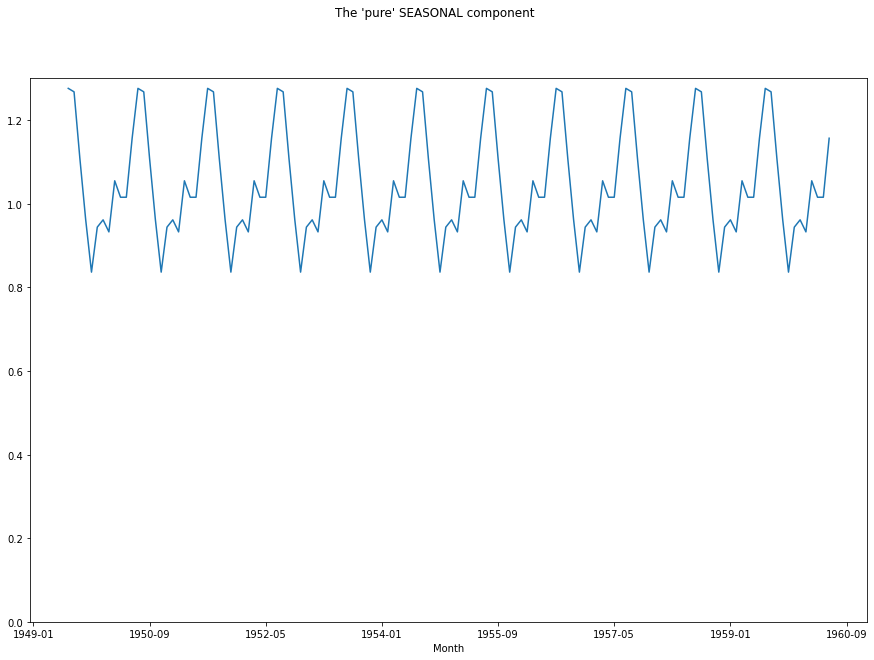

In [94]:
# stworzenie kolumny miesięcy

months = []
for i in range(df['SEASONALITY_WITH_NOISE'].size):
    months.append((i)%12 + 1)
df['MONTH'] = months
 
# stworzenie słowników, w których zliczane są sumy wartości szeregu dla poszczególnych miesięcy oraz ilość 
# zsumowanych elementów dla każdego z 12 miesięcy
average_seasonal_values = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}
 
average_seasonal_value_counts = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}
 
# sumowanie i zliczanie wartości szergu dla poszczególnych miesięcy
for i in range(0, df['SEASONALITY_WITH_NOISE'].size):
    if math.isnan(df['SEASONALITY_WITH_NOISE'][i]) is False:
        average_seasonal_values[df['MONTH'][i]] = average_seasonal_values[df['MONTH'][i]] + df['SEASONALITY_WITH_NOISE'][i]
        average_seasonal_value_counts[df['MONTH'][i]] = average_seasonal_value_counts[df['MONTH'][i]] + 1

# obliczamy średnią dla każdego miesiąca
for i in range(1, 13):
    average_seasonal_values[i] = average_seasonal_values[i] / average_seasonal_value_counts[i]

# inicjalizacja kolumny opisującej sezonowość
df['SEASONALITY'] = np.nan

# 
for i in range(0, df['SEASONALITY_WITH_NOISE'].size):
    if math.isnan(df['SEASONALITY_WITH_NOISE'][i]) is False:
        df['SEASONALITY'][i] = average_seasonal_values[df['MONTH'][i]]
    


# Rysowanie wykresu sezonowości
fig = plt.figure()
 
fig.suptitle('The \'pure\' SEASONAL component')
 
plt.ylim(0, 1.3)
 
df['SEASONALITY'].plot()
 
plt.show()

Teraz aby otrzymać szum wystarczy podzielić czynnik sezonowości z szumem przez otrzymaną wartość sezonowości

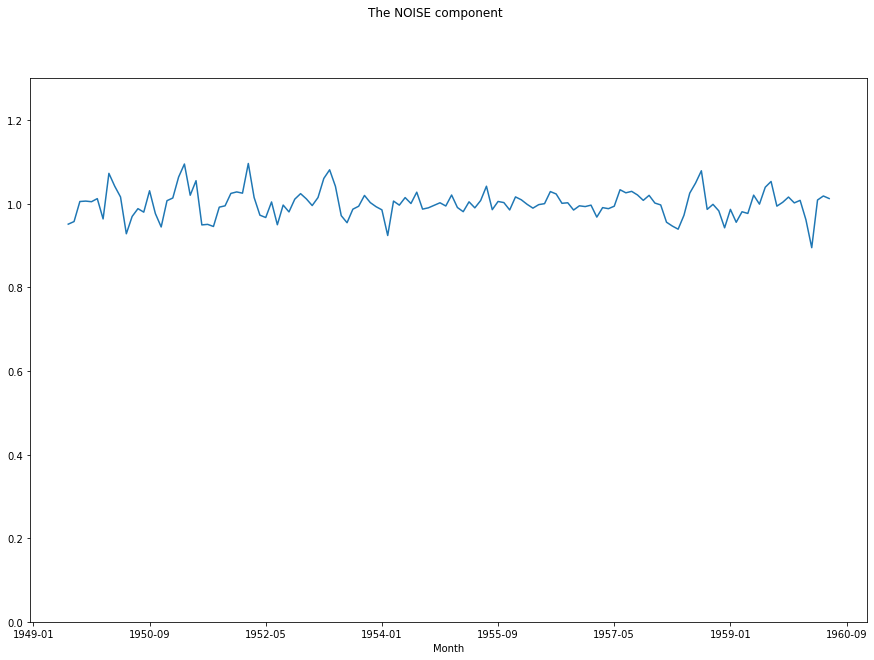

In [95]:
df['NOISE'] = df['SEASONALITY_WITH_NOISE']/df['SEASONALITY']
 
#plot the seasonal component
 
fig = plt.figure()
 
fig.suptitle('The NOISE component')
 
plt.ylim(0, 1.3)
 
df['NOISE'].plot()
 
plt.show()